# 심리상담 데이터를 통해서 심리상담을 해주는 모델 만들기
##(TASK : 소설 창작과 같은 seqGAN에서 착안하여 주어진 몇개의 단어를 가지고 상담자의 심리를 파악하여 심리상담 글을 작성해주기)

목차
1. 사용할 데이터 가져오기(웹크롤링,네이버지식인 서울시청년사이버상담내역)
2. 데이터 전처리 및 데이터 벡터화(Fasttext를 사용)
3. seqGAN(생성자,감별자)를 사용하여 상담글 생성하기(미완)

한계점 및 아쉬운점
1. 적절한 데이터를 찾는 데 너무 많은 시간을 소비해서 제대로 모델을 만져보지 못했다.
2. seqGAN에 대한 예시나 선행 과정이 한국어로는 거의 전무한 상태인 것 같다.
3. 한국어를 자소분리한 형태로 FASTTEXT에 활용해보려고 했으나 현재 내가 찾은 seqGAN모델이 Word2vec을 사용하여 vocab을 만들어서 활용하는 모델이였고 찾아본 다른 프로젝트에서도 비슷한 구조로 진행을 하는 것 같다. 더 좋은 성능을 발휘하지 않을까해서 시도해본 것인데 내 실력으로 전체적인 GAN 구조를 바꾸면서 진행을 해야하기에는 무리였던 것 같다.
4. 이 모델을 완성하여 어느정도 비슷한 상담내용을 만들 수 있더라도 과연 정신적으로 불안하며 많은 변수가 존재하는 인간의 심리를 인공지능이 맞출 수 있을까라는 한계점이 보였다. 또한, 불안정한 심리를 거스르는 것이야 말로 독이 되는 행위이기때문에 암환자 양성검사와 같이 재현율(Recall)을 높히는 방향으로의 설계가 필요하다고 생각되었습니다.

###1.데이터 생성하기
- 사용할 데이터를 수집하기 위해 웹크롤링을 통해 네이버지식인의 서울시청년사이버상담의 2021년 답변을 모두 스크래핑하여 훈련데이터를 구성하기로 했습니다.

In [10]:
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
#from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
import sqlite3
import joblib
import pickle
import re

In [11]:
#데이터 불러오기
conn= sqlite3.connect("/content/drive/MyDrive/코드스테이츠 과제/project4/url_data.db")
cur = conn.cursor()
query = cur.execute("SELECT * FROM dataset")
cols = [column[0] for column in query.description]
df = pd.DataFrame.from_records(data=query.fetchall(),columns=cols)
#데이터베이스 닫기
conn.close()

In [8]:
df.head()

,counseling
0,"안녕하세요, 서울시청소년상담복지센터 사이버상담원입니다.​​song*..."
1,너무 성적에 연연하지 마시고 틀릴때마다 약간 완벽하게 하지 못해서 ...
2,숙제를 열심히 한것 아닐까요? 원래 열심히 할 수록 잘못되면 짜증나...
3,학교 상담하는곳 있음.
4,상담 자체로도 큰 효과를 볼 수 있는 경우도 많기에 학생이시라면 학...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   counseling  1089 non-null   object
dtypes: object(1)
memory usage: 8.6+ KB


In [12]:
#정규포현식 사용하여 공백 및 필요없는 내용 삭제하기 (/n,\u200b)

def preprocess_sentence_kr(w):
  w = w.strip()
  w = re.sub(r"[^0-9가-힣?.!,¿]+", " ", w) # \n도 공백으로 대체해줌
  w = w.strip()
  return w

In [13]:
df['counseling'] = [preprocess_sentence_kr(l) for l in df['counseling']]

In [5]:
#적용이 안됐음..
#df['counseling']=df['counseling'].replace('\u200b','')

In [12]:
df['counseling'][5]

'안녕하세요, 서울시청소년상담복지센터 사이버상담원입니다. 님이 올려주신 글을 잘 읽어보았어요. 자세한 내용은 모르겠지만, 님께 상처로 남은 일이 있을 것 같고, 마음이 아프고 괴롭겠어요. 그래서 심리상담을 받아보고 싶은데, 돈이 들지 않으면서 부모님께 알려지지 않는 곳은 없을 것 같아서 마음에 걸렸군요. 정보를 알려주고 싶어서 답변을 남겨요. 만 9세 24세 청소년은 시군구 청소년상담복지센터에서 무료 또는 저렴한 비용으로 상담을 받을 수 있어요. 상담을 시작할 때는 부모님 동의가 필요할 수 있지만, 자신이나 타인을 해칠 우려가 있는 경우가 아니면 상담 내용은 비밀이 보장돼요. 님 집 근처 센터에 전화로 문의하여 상담을 신청할 수 있고, 연락처는 아래 사이트 내용을 참고해주세요. 청소년상담복지센터 지역센터 안내 . . . . ? 1 상담을 받으면서 님 마음이 점차 괜찮아지고, 상담선생님과 함께 어려움을 풀어갈 수 있다면 좋겠어요. 아직 센터로 가기 어렵다면 저희 서울시청소년상담복지센터 홈페이지에 오셔서 게시판 상담과 채팅 상담 월, 목 12시 7시 가능 5시 6시 제외 을 먼저 하실 수도 있으니 참고해주세요. 제 답변이 조금이나마 도움이 되길 바랄게요. 서울시청소년상담복지센터 사이버상담원 드림'

In [13]:
df['counseling'][0]

'안녕하세요, 서울시청소년상담복지센터 사이버상담원입니다. 님이 올려주신 글을 잘 읽어보았어요. 내가 원하는대로 되지 않아서 짜증과 화가 나고, 괴로울 때가 있지요. 님은 요즘 주로 수학 문제를 풀고 나서 틀린 문제가 있으면 마음에 많이 걸리고, 괴롭군요. 그렇지만 완벽한 사람은 없기 때문에 누구나 실수를 하게 마련이고, 수학을 배워가는 과정에 있으므로 틀리는 문제가 있을 수도 있지요. 님은 공부를 완벽하게, 잘 하고 싶은 마음이 많으신 것 같아요. 잘 하고 싶은 마음이 있으면 학업에 도움이 되기도 하지만, 그러한 마음이 너무 커지면 스스로에게 기대가 너무 높아져서 부담스럽고, 괴로워지지요. 어쩌면 님 마음에 잘 해야 한다 는 기준이 높아서 몇 문제만 틀려도 화와 짜증이 나고, 눈물이 날 수도 있겠어요. 먼저 수학을 잘 하고 싶은데 잘 되지 않아서 화가 났지 하면서 자신의 마음을 이해해주면 좋겠어요. 한편, 틀린 문제를 살펴보면서 다음에는 어떻게 문제를 풀어볼지 생각해보고, 점차 실력을 쌓아가게 되지요. 틀린 문제 갯수보다는 배워가는 과정임을 떠올려보고, 실력을 더 쌓아보는 계기로 삼아보면 어떨까 싶어요. 문제를 틀릴 수도 있지, 괜찮아, 배워가는 중이야 하면서 스스로를 다독여주고, 좀 더 기회를 주는 연습을 해보면 좋겠어요. 제 답변이 조금이나마 위로가 되고, 도움이 되길 바랄게요. 만 9세 24세 청소년은 저희 서울시청소년상담복지센터를 이용하실 수 있으니 더 도움받고 싶은 주제가 있을 때 언제든 찾아주세요. 서울시청소년상담복지센터 사이버상담원 드림'

In [ ]:
#konlpy 설치
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [17]:
# 토큰화 시키기 시험용
from konlpy.tag import Kkma
kkma=Kkma()
print(kkma.morphs(df['counseling'][0]))

['안녕', '하세', '요', ',', '서울시', '청소년', '상담', '복지', '센터', '사이버', '상담원', '이', 'ㅂ니다', '.', '니', 'ㅁ', '이', '올리', '어', '주신', '글', '을', '잘', '읽', '어', '보', '았', '어요', '.', '내', '가', '원하', '는', '대로', '되', '지', '않', '아서', '짜증', '과', '화가', '나', '고', ',', '괴롭', 'ㄹ', '때', '가', '있', '지요', '.', '니', 'ㅁ', '은', '요즘', '주로', '수학', '문제', '를', '풀', '고', '나', '서', '틀리', 'ㄴ', '문제', '가', '있', '으면', '마음', '에', '많이', '걸리', '고', ',', '괴롭', '군요', '.', '그렇', '지만', '완벽', '하', 'ㄴ', '사람', '은', '없', '기', '때문', '에', '누구', '나', '실수', '를', '하', '게', '마련', '이', '고', ',', '수학', '을', '배워가', '는', '과정', '에', '있', '으므로', '틀리', '는', '문제', '가', '있', '을', '수', '도', '있', '지요', '.', '니', 'ㅁ', '은', '공부', '를', '완벽', '하', '게', ',', '잘', '하', '고', '싶', '은', '마음', '이', '많', '으시', 'ㄴ', '것', '같', '아요', '.', '잘', '하', '고', '싶', '은', '마음', '이', '있', '으면', '학업', '에', '도움', '이', '되', '기', '도', '하', '지만', ',', '그러하', 'ㄴ', '마음', '이', '너무', '커지', '면', '스스로', '에게', '기대', '가', '너무', '높', '아', '지', '어서', '부담', '스럽', '고', ',', '괴', '로', '워', '지', '지

In [18]:
# 토큰화 시키기
%%time
df['token']= df['counseling'].apply(kkma.morphs)

CPU times: user 7min 35s, sys: 2.08 s, total: 7min 37s
Wall time: 5min 33s


In [19]:
df['token'].head()

0    [안녕, 하세, 요, ,, 서울시, 청소년, 상담, 복지, 센터, 사이버, 상담원,...
1    [너무, 성적, 에, 연연, 하, 지, 마시, 고, 틀리, ㄹ, 때, 마다, 약간,...
2    [숙제, 를, 열심히, 하, ㄴ, 것, 아니, ㄹ까요, ?, 원래, 열심히, 하, ...
3                             [학교, 상담, 하, 는, 곳, 있음, .]
4    [상담, 자체, 로, 도, 크, ㄴ, 효과, 를, 보, ㄹ, 수, 있, 는, 경우,...
Name: token, dtype: object

In [20]:
# 생성된 토큰 비율 확인
from collections import Counter
def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [21]:
wc = word_count(df['token'])
wc.head(10)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
107,하,1018,12145,1.0,0.041722,0.041722,0.934803
70,.,924,11039,2.0,0.037923,0.079645,0.848485
67,이,971,8963,3.0,0.030791,0.110435,0.891644
157,을,894,8243,4.0,0.028317,0.138753,0.820937
123,는,954,6451,5.0,0.022161,0.160914,0.876033
166,",",738,6349,6.0,0.021811,0.182725,0.677686
111,고,865,6077,7.0,0.020876,0.203602,0.794307
26,있,840,4731,8.0,0.016253,0.219854,0.771350
148,ㄴ,855,4457,9.0,0.015311,0.235165,0.785124
51,어,840,4144,10.0,0.014236,0.249401,0.771350


In [22]:
#불용어 없애기
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = "아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓 , ."

word_tokens = df['token']
stop_words=stop_words.split(' ')

result = []

for doc in word_tokens:
    
    doc_tokens = []

    for w in doc: 
        if w not in stop_words: 
            doc_tokens.append(w) 

    result.append(doc_tokens)

df['token_1'] = result

In [23]:
df['token'].head()

0    [안녕, 하세, 요, ,, 서울시, 청소년, 상담, 복지, 센터, 사이버, 상담원,...
1    [너무, 성적, 에, 연연, 하, 지, 마시, 고, 틀리, ㄹ, 때, 마다, 약간,...
2    [숙제, 를, 열심히, 하, ㄴ, 것, 아니, ㄹ까요, ?, 원래, 열심히, 하, ...
3                             [학교, 상담, 하, 는, 곳, 있음, .]
4    [상담, 자체, 로, 도, 크, ㄴ, 효과, 를, 보, ㄹ, 수, 있, 는, 경우,...
Name: token, dtype: object

In [24]:
df['token_1'].head()

0    [안녕, 하세, 요, 서울시, 청소년, 상담, 복지, 센터, 사이버, 상담원, ㅂ니...
1    [너무, 성적, 연연, 마시, 고, 틀리, ㄹ, 마다, 완벽, 게, 어서, 목표, ...
2    [숙제, 열심히, ㄴ, ㄹ까요, ?, 원래, 열심히, ㄹ, 수록, 잘못되, 면, 짜...
3                                   [학교, 상담, 는, 곳, 있음]
4    [상담, 자체, 도, ㄴ, 효과, ㄹ, 는, 도, 기에, 학생, 시, 라면, 학, ...
Name: token_1, dtype: object

In [25]:
wc = word_count(df['token_1'])
wc.head(10)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
91,는,954,6451,1.0,0.037844,0.037844,0.876033
84,고,865,6077,2.0,0.035650,0.073493,0.794307
107,ㄴ,855,4457,3.0,0.026146,0.099639,0.785124
40,상담,646,3755,4.0,0.022028,0.121667,0.593205
116,ㄹ,839,3728,5.0,0.021870,0.143537,0.770432
122,은,812,3136,6.0,0.018397,0.161934,0.745638
41,어요,609,2453,7.0,0.014390,0.176324,0.559229
49,시,742,2240,8.0,0.013141,0.189464,0.681359
103,도,711,2070,9.0,0.012143,0.201607,0.652893
113,ㅂ니다,875,2039,10.0,0.011961,0.213569,0.803489


In [26]:
!pip install gensim --upgrade

     |████████████████████████████████| 24.1 MB 2.1 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


토큰의 최대 길이 : 4233
토큰의 평균 길이 : 156.53351698806244


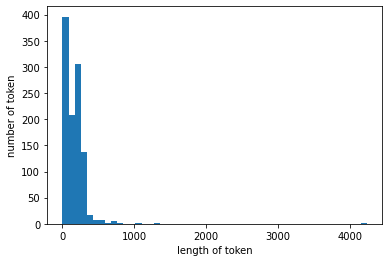

In [62]:
#토큰 길이 확인하기
import matplotlib.pyplot as plt

print('토큰의 최대 길이 :',max(len(l) for l in df['token_1']))
print('토큰의 평균 길이 :',sum(map(len, df['token_1']))/len(df['token_1']))
plt.hist([len(s) for s in df['token_1']], bins=50)
plt.xlabel('length of token')
plt.ylabel('number of token')
plt.show()

- 데이터 임베딩 ( word2vec이냐 fasttext이냐 )

In [30]:
#word2vec적용하기
#from gensim.models import Word2Vec
#model = Word2Vec(sentences = df['token_1'], size = 400, window = 5, min_count = 10, workers = 4, sg = 0)

In [28]:
pip install jamo

In [29]:
%pwd

'/content/drive/My Drive/코드스테이츠 과제/project4'

In [7]:
%cd /content/drive/MyDrive/코드스테이츠 과제/project4

/content/drive/MyDrive/코드스테이츠 과제/project4


In [30]:
from jamo import h2j, j2hcj 
from unicode import join_jamos 

text = "동해물과 백두산이 마르고 닳도록" 
jamo_str = j2hcj(h2j(text)) 
print(jamo_str) 

merge_jamo = join_jamos(jamo_str) 
print(merge_jamo)

ㄷㅗㅇㅎㅐㅁㅜㄹㄱㅘ ㅂㅐㄱㄷㅜㅅㅏㄴㅇㅣ ㅁㅏㄹㅡㄱㅗ ㄷㅏㅀㄷㅗㄹㅗㄱ
동해물과 백두산이 마르고 닳도록


In [ ]:
df['token_1'][0]

In [31]:
word_tokens = df['token_1']

corpus = []

for doc in word_tokens:
    
    corpus_tokens = []

    for w in doc: 
        w = j2hcj(h2j(w)) 
        corpus_tokens.append(w)

    corpus.append(corpus_tokens)

df['token_corpus'] = corpus

In [ ]:
df['token_corpus'][0]

토큰의 최대 길이 : 4233
토큰의 평균 길이 : 156.53351698806244


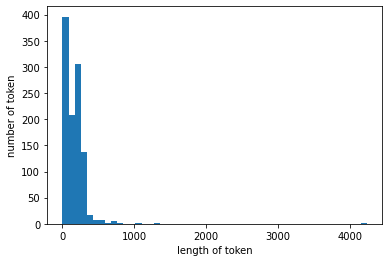

In [64]:
print('토큰의 최대 길이 :',max(len(l) for l in df['token_corpus']))
print('토큰의 평균 길이 :',sum(map(len, df['token_corpus']))/len(df['token_corpus']))
plt.hist([len(s) for s in df['token_corpus']], bins=50)
plt.xlabel('length of token')
plt.ylabel('number of token')
plt.show()

In [116]:
#fasttext 적용하기  
from gensim.models import FastText
model = FastText(df['token_corpus'], vector_size=50, workers=4, sg=1, word_ngrams=1, min_count =3) #iter=2,
print(f"학습 소요 시간 : {model.total_train_time}")

학습 소요 시간 : 8.631763424999008


In [118]:
#fasttext vocab만들기
model.build_vocab(df['token_corpus'])

In [117]:
#fasttext 훈련시키기
model.train(
    df['token_corpus'], epochs=model.epochs,
    total_examples=model.corpus_count, total_words=model.corpus_total_words,
)

(622127, 852325)

In [100]:
def transform(list): 
  return [(join_jamos(w), r) for (w, r) in list]

In [101]:
print(transform(model.wv.most_similar(j2hcj(h2j('친구')), topn=5)))
print(transform(model.wv.most_similar(j2hcj(h2j('고민')), topn=5)))
print(transform(model.wv.most_similar(j2hcj(h2j('엄마')), topn=5)))
print(transform(model.wv.most_similar(j2hcj(h2j('진로')), topn=5)))

[('친하', 0.9386789202690125), ('친', 0.9297067523002625), ('옆', 0.9081870913505554), ('걸', 0.9076166152954102), ('만남', 0.9046932458877563)]
[('힘들', 0.8791881799697876), ('고맙', 0.8772603273391724), ('엄마', 0.869956910610199), ('끌', 0.8622254729270935), ('터놓', 0.8609519600868225)]
[('엄두', 0.9541079998016357), ('언제나', 0.9497414827346802), ('어플', 0.9474387168884277), ('어머니', 0.9464944005012512), ('어느새', 0.9448943138122559)]
[('진리', 0.8584847450256348), ('진화', 0.8279927372932434), ('지니', 0.8151033520698547), ('입학제', 0.8125683665275574), ('진료', 0.8096590042114258)]


In [102]:
df['token_corpus'].shape

(1089,)

In [129]:
ft_word_to_index = model.wv.key_to_index
ft_index_to_word = dict([(value, key) for (key, value) in ft_word_to_index.items()])

In [ ]:
# 의문점.. 인코딩을 따로 안해도 되는 것인가..? 해야할 거 같은데 자소분리된 문자를 인코딩해도 되는 건지 고민이 필요하다.
word_to_index={}
index_to_word={}
for word_encoder in df['token_corpus'] :
  cnt=Counter(word_encoder)

# 빈도수 기준 내림차순 정렬 / Counter 사용시 이미 내림차순 정렬됨.
  vocab_sorted=sorted(cnt.items(), key = lambda x:x[1], reverse = True)
  #print(vocab_sorted)

# 2개 이상만 사전에 포함시키기.
  for idx,(word,freq) in enumerate(vocab_sorted):
      if freq<1:
          continue
      word_to_index[word]=idx+1
      index_to_word[idx+1]=word
    
# 없는 단어 인덱스 추가
#word_to_index['OOV'] = len(word_to_index) + 1
#index_to_word[len(index_to_word)+1] = 'OOV'

word_to_index, index_to_word

In [128]:
encoded = []
for s in corpus:
    temp = []
    for w in s:
      temp.append(ft_word_to_index[w])
    encoded.append(temp)
print(encoded)

KeyError: ignored

In [ ]:
ft_word_to_index

In [67]:
#임베딩 벡터 만들기
import numpy as np
key = list(word_to_index.keys())
fasttext = []
for k in key:
    fasttext.append(model.wv[k])

fasttext=np.array(fasttext)

In [41]:
fasttext.shape

(7819, 50)

... 자소분리를 하지 않은 토큰을 fasttext에 적용하는 방법

In [121]:
#fasttext 적용하기  
from gensim.models import FastText
model_no = FastText(df['token_1'], vector_size=10, workers=4, sg=1, word_ngrams=1, min_count =3) #iter=2,
print(f"학습 소요 시간 : {model_no.total_train_time}")

학습 소요 시간 : 3.216515234000326


In [122]:
#fasttext vocab만들기
model_no.build_vocab(df['token_1'])

In [123]:
#fasttext 훈련시키기
model_no.train(
    df['token_1'], epochs=model.epochs,
    total_examples=model.corpus_count, total_words=model.corpus_total_words,
)

(621830, 852325)

In [125]:
ft_word_to_index_no = model_no.wv.key_to_index
ft_index_to_word_no = dict([(value, key) for (key, value) in ft_word_to_index_no.items()])

In [130]:
encoded_no = []
for s in df['token_1']:
    temp = []
    for w in s:
      temp.append(ft_word_to_index_no[w])
    encoded_no.append(temp)
print(encoded_no)

KeyError: ignored

##- 피상담자의 문장을보고 상담해주는 글을 만들어보자 (seqGAN)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df['counseling'], test_size= 0.2, random_state=1234)

In [90]:
def decode_review(text):
    """
    word_index를 받아 text를 sequence 형태로 반환하는 함수입니다.
    """
    return ' '.join([ft_index_to_word.get(i,'?') for i in text])

In [127]:
join_jamos(decode_review(encoded[0]))

IndexError: ignored

In [52]:
sentences = [join_jamos(decode_review(idx)) for idx in encoded]

In [60]:
df['counseling'][4]

'상담 자체로도 큰 효과를 볼 수 있는 경우도 많기에 학생이시라면 학교사회복지사를 찾아가는 것을 추천드려요 그분과 상담을 진행하면서 큰 도움이 될 수도 있을 것이며 이분을 통해 지역사회에 있는 상담이 가능한 곳에 연계하여 진행 할 수 있답니다. 학교에서 상담을 진행하는 경우 비용이 발생하지 않지만 지역사회에 있는 센터를 이용할 경우 무료로 이용할 수도 혹은 비용이 발생할 수 있기에 이것에 대하여 고려해야할 필요가 있을것 같아요. 질문에 대한 답변이 되었다면 채택부탁드립니다.'

In [59]:
sentences[4]

'상담 감정 도 ㄴ 소년 ㄹ 는 도 번호 친구 시 드리 ㅁ ㄴ가 사이버 ㄴ 5 는 집중력 전문 선생님 올리 상담 8 플러스 ㄴ 도움 ㄹ 도 고민 안녕 글로 는 상담 가능 ㄴ 무겁 요즘 8 ㄹ 친구 기 상담 8 는 요즘 발생 글로 는 센터 이용 ㄹ 무료 이용 ㄹ 으니 요즘 발생 ㄹ 번호 시 어야 ㄹ 읽 아요 자주 ㄴ 답변 친구 무료 청소년 안녕 ㅂ니다'

In [149]:
import numpy as np
#import tensorflow as tf
import random
from dataloader import Gen_Data_loader, Dis_dataloader
#from generator_1 import Generator
#from discriminator import Discriminator
from rollout import ROLLOUT
import pickle
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()




#########################################################################################
#  Generator  Hyper-parameters
######################################################################################
EMB_DIM = 30 # embedding dimension (pretrained: 200, pk: 30)
HIDDEN_DIM = 300 # hidden state dimension of lstm cell
SEQ_LENGTH = 30 # sequence length
START_TOKEN = 0
PRE_EPOCH_NUM = 120  # supervise (maximum likelihood estimation) epochs
SEED = 88
BATCH_SIZE = 64

#########################################################################################
#  Discriminator  Hyper-parameters
#########################################################################################
dis_embedding_dim = EMB_DIM
dis_filter_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 30]
dis_num_filters = [100, 200, 200, 200, 200, 100, 100, 100, 100, 100, 160, 160]
dis_dropout_keep_prob = 0.75
dis_l2_reg_lambda = 0.2
dis_batch_size = 64

#########################################################################################
#  Basic Training Parameters
#########################################################################################
TOTAL_BATCH = 200
generated_num = 100
sample_num = 10

# original seqgan parameter
# HIDDEN_DIM = 32
# PRE_EPOCH_NUM = 120
# TOTAL_BATCH = 200
# generated_num = 10000

positive_file = df['counseling']
negative_file = 'save/negative_sample.txt'
eval_file = 'save/eval_file.txt'

real_data = encoded

vocab_to_int = word_to_index

int_to_vocab = index_to_word
print(int_to_vocab)

word_embedding_matrix = fasttext
word_embedding_matrix = fasttext.astype(np.float32)

#real_data_vocab = [[int_to_vocab[i] for i in sample if int_to_vocab[i] != '<PAD>'] for sample in real_data]
real_data_vocab = [decode_review(encoded[i]) for i in range(0,len(encoded))]
real_data_vocab = join_jamos(real_data_vocab)
print(len(real_data_vocab))


def generate_samples(sess, trainable_model, batch_size, generated_num, output_file, word_embedding_matrix):
    # Generate Samples
    generated_samples = []
    for _ in range(int(generated_num / batch_size)):
        generated_samples.extend(trainable_model.generate(sess, word_embedding_matrix))

    with open(output_file, 'w') as fout:
        for poem in generated_samples:
            buffer = ' '.join([str(x) for x in poem]) + '\n'
            fout.write(buffer)


def pre_train_epoch(sess, trainable_model, data_loader, word_embedding_matrix):
    # Pre-train the generator using MLE for one epoch
    supervised_g_losses = []
    data_loader.reset_pointer()

    for it in range(data_loader.num_batch):
        batch = data_loader.next_batch()
        _, g_loss = trainable_model.pretrain_step(sess, batch, word_embedding_matrix)
        supervised_g_losses.append(g_loss)

    return np.mean(supervised_g_losses)


def make_sample(eval_file, int_to_vocab, sample_num):
    samples = []
    with open(eval_file, 'r') as f:
        for line in f:
            line = line.strip()
            line = line.split()
            parse_line = [int(x) for x in line]
            samples.append(parse_line)

    sample_int = samples[:sample_num]
    sample_vocab = [[int_to_vocab[i] for i in sample] for sample in sample_int]
    sample_vocab = [' '.join(sample) for sample in sample_vocab]

    return sample_vocab

################################## main() #########################################

# 시간측정
start_time = time.time()

tf.compat.v1.reset_default_graph()

random.seed(SEED)
np.random.seed(SEED)

gen_data_loader = Gen_Data_loader(BATCH_SIZE, SEQ_LENGTH)
vocab_size = len(vocab_to_int)  # 6447
print(vocab_size)
dis_data_loader = Dis_dataloader(BATCH_SIZE, SEQ_LENGTH)

generator = Generator(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN)
discriminator = Discriminator(sequence_length=SEQ_LENGTH, num_classes=2, word_embedding_matrix=word_embedding_matrix,
                              embedding_size=dis_embedding_dim, filter_sizes=dis_filter_sizes,
                              num_filters=dis_num_filters, l2_reg_lambda=dis_l2_reg_lambda)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

# First, use the oracle model to provide the positive examples, which are sampled from the oracle data distribution
#  pre-train generator
#gen_data_loader.create_batches(positive_file)
#gen_sample = open('save/pretrain_sample.txt', 'w')
#print('Start pre-training...')
#gen_sample.write('pre-training...\n')
for epoch in range(PRE_EPOCH_NUM):
    loss = pre_train_epoch(sess, generator, gen_data_loader, word_embedding_matrix)
    if epoch % 5 == 0:
        generate_samples(sess, generator, BATCH_SIZE, generated_num, eval_file, word_embedding_matrix)
        sample_vocab = make_sample(eval_file, int_to_vocab, sample_num)

        print('pre-train epoch ', epoch)

        buffer = 'epoch:\t' + str(epoch) + '\n'
        gen_sample.write(buffer)
        for sample in sample_vocab:
            print(sample)
            buffer = sample + '\n'
            gen_sample.write(buffer)

#  pre-train discriminator
print('Start pre-training discriminator...')
# Train 3 epoch on the generated data and do this for 50 times
for _ in range(25):
    generate_samples(sess, generator, BATCH_SIZE, generated_num, negative_file, word_embedding_matrix)
    dis_data_loader.load_train_data(positive_file, negative_file)
    for _ in range(3):
        dis_data_loader.reset_pointer()
        for it in range(dis_data_loader.num_batch):
            x_batch, y_batch = dis_data_loader.next_batch()
            feed = {
                discriminator.input_x: x_batch,
                discriminator.input_y: y_batch,
                discriminator.dropout_keep_prob: dis_dropout_keep_prob
            }
            _ = sess.run(discriminator.train_op, feed)

rollout = ROLLOUT(generator, 0.8, word_embedding_matrix)

print('#########################################################################')
print('Start Adversarial Training...')
gen_sample.write('adversarial training...\n')
for total_batch in range(TOTAL_BATCH):
    # Train the generator for one step
    for it in range(1):
        samples = generator.generate(sess, word_embedding_matrix)
        rewards = rollout.get_reward(sess, samples, 16, discriminator)
        feed = {generator.x: samples, generator.rewards: rewards, generator.word_embedding_matrix: word_embedding_matrix}
        _ = sess.run(generator.g_updates, feed_dict=feed)

    # Test
    if total_batch % 5 == 0 or total_batch == TOTAL_BATCH - 1:
        generate_samples(sess, generator, BATCH_SIZE, generated_num, eval_file, word_embedding_matrix)
        sample_vocab = make_sample(eval_file, int_to_vocab, sample_num)

        print('total_batch: ', total_batch)

        buffer = 'epoch:\t' + str(total_batch) + '\n'
        gen_sample.write(buffer)
        for sample in sample_vocab:
            print(sample)
            buffer = sample + '\n'
            gen_sample.write(buffer)

    # Update roll-out parameters
    rollout.update_params()

    # Train the discriminator
    for _ in range(5):
        generate_samples(sess, generator, BATCH_SIZE, generated_num, negative_file, word_embedding_matrix)
        dis_data_loader.load_train_data(positive_file, negative_file)

        for _ in range(3):
            dis_data_loader.reset_pointer()
            for it in range(dis_data_loader.num_batch):
                x_batch, y_batch = dis_data_loader.next_batch()
                feed = {
                    discriminator.input_x: x_batch,
                    discriminator.input_y: y_batch,
                    discriminator.dropout_keep_prob: dis_dropout_keep_prob
                }
                _ = sess.run(discriminator.train_op, feed)

    if total_batch % 5 == 0 or total_batch == TOTAL_BATCH - 1:
        saver.save(sess, './checkpoint/seqGAN_ours')

gen_sample.close()

# 걸린 시간 출력
time_check = "--- total {} seconds ---".\
    format(time.time() - start_time)
print(time_check)

generate_samples(sess, generator, BATCH_SIZE, generated_num, eval_file, word_embedding_matrix)

samples = make_sample(eval_file, int_to_vocab, generated_num)
samples = [[word for word in sample.split() if word != 'UNK'] for sample in samples]
samples = [' '.join(sample) for sample in samples]

#f = open('./save/final_output_vocab.txt', 'w')
#for token in samples:
#    token = token + '\n'
#    f.write(token)
#f.close()

# write the training time
#f = open('./save/_parameters.txt', 'w')
#f.write("Training time : {}\n".format(time_check))
#f.write("add <start> signal as zero in word2vec lookup table\n")
#f.close()

{1: 'ㅅㅏㅇㄷㅏㅁ', 2: 'ㄱㅗ', 3: 'ㅅㅣ', 4: 'ㅇㅡㄴ', 5: 'ㅁㅜㄴㅈㅏ', 6: 'ㅅㅔㄴㅌㅓ', 7: 'ㅇㅓㅇㅛ', 8: 'ㄴ', 9: 'ㅌㅗㄱ', 10: 'ㄱㅏㄴㅡㅇ', 11: 'ㅂㅗㄱㅈㅣ', 12: 'ㅅㅏㅇㅣㅂㅓ', 13: 'ㅅㅏㅇㄷㅏㅁㅇㅝㄴ', 14: 'ㄴㅐㅇㅛㅇ', 15: 'ㄱㅔㅆ', 16: 'ㅇㅓㅅㅓ', 17: 'ㅇㅣㅇㅑㄱㅣ', 18: 'ㄴㅡㄴ', 19: 'ㅋㅏ', 20: 'ㄹ', 21: 'ㄹㄱㅔㅇㅛ', 22: '1388', 23: 'ㅂㅗㄴㅐ', 24: 'ㅊㅣㄴㄱㅜ', 25: 'ㄱㅣ', 26: 'ㄷㅏㅂㅂㅕㄴ', 27: '24', 28: 'ㅇㅣㅇㅛㅇ', 29: 'ㅇㅏㄴㄴㅕㅇ', 30: 'ㅎㅏㅅㅔ', 31: 'ㅇㅛ', 32: 'ㅅㅓㅇㅜㄹㅅㅣ', 33: 'ㅊㅓㅇㅅㅗㄴㅕㄴ', 34: 'ㅂㄴㅣㄷㅏ', 35: 'ㄴㅣ', 36: 'ㅁ', 37: 'ㅇㅗㄹㄹㅣ', 38: 'ㅈㅜㅅㅣㄴ', 39: 'ㄱㅡㄹ', 40: 'ㅇㅣㄺ', 41: 'ㅇㅏㅆ', 42: 'ㅈㅏㅅㅔ', 43: 'ㅇㅛㅈㅡㅁ', 44: 'ㅇㅜㅇㅜㄹ', 45: 'ㄱㅏㅁㅈㅓㅇ', 46: 'ㅈㅏㅈㅜ', 47: 'ㄴㅡㄲㅣ', 48: 'ㅁㅏㅇㅡㅁ', 49: 'ㅁㅜㄱㅓㅂ', 50: 'ㅎㅣㅁㄷㅡㄹ', 51: 'ㅇㅡㄴㄷㅔ', 52: 'ㅂㅗㄷㅏ', 53: 'ㄱㅡㄹㄹㅗ', 54: 'ㅍㅕㄴㅎㅏ', 55: 'ㄴㄱㅏ', 56: 'ㅇㅏㅇㅛ', 57: 'ㅇㅣㄴㅏ', 58: 'ㄱㅣㄱㅘㄴ', 59: 'ㅇㅏㄴㄴㅐ', 60: 'ㄷㅡㄹㅣ', 61: 'ㅎㅐㄴㄷㅡㅍㅗㄴ', 62: 'ㅂㅗㄴㅐㄱㅣ', 63: 'ㅅㅜㅅㅣㄴㅈㅏ', 64: 'ㅂㅓㄴㅎㅗ', 65: 'ㅆㅡ', 66: 'ㄱㅗㅁㅣㄴ', 67: 'ㄱㅓㄴㅏ', 68: 'ㅋㅏㅋㅏㅇㅗ', 69: 'ㅍㅡㄹㄹㅓㅅㅡ', 70: 'ㅁㅐㅈ', 71: 'ㅋㅏㅋㅏㅇㅗㅌㅗㄱㅇㅡ', 72: 'ㅁㅕㄴ', 73: 'ㅈㅓㄴㅁㅜㄴ', 74: 'ㅅㅓㄴㅅㅐㅇㄴㅣㅁ', 75: 'ㅁㅜㄹㅛ', 76: 'ㄷㅔㅇㅣㅌㅓ', 77: 'ㅇㅛㄱㅡㅁ', 78: 'ㅇㅣㅇㅛㅇㅈㅏ', 79: 'ㅂㅜㄷㅏㅁ', 80: 'ㅇㅔㅇㅛ', 

AttributeError: ignored

생성자,감별자 모델 생성

In [138]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from tensorflow.python.ops import tensor_array_ops, control_flow_ops

class Generator(object):
    def __init__(self, num_emb, batch_size, emb_dim, hidden_dim,
                 sequence_length, start_token,
                 learning_rate=0.01, reward_gamma=0.95):
        self.num_emb = num_emb
        self.batch_size = batch_size
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token_input = np.array([start_token] * self.batch_size, dtype=np.int32)
        self.word_embedding_matrix = tf.placeholder(dtype=tf.float32, shape=[num_emb, emb_dim], name='word_embed')
        self.learning_rate = tf.Variable(float(learning_rate), trainable=False)
        self.reward_gamma = reward_gamma
        self.g_params = []
        self.d_params = []
        self.temperature = 1.0
        self.grad_clip = 5.0

        self.expected_reward = tf.Variable(tf.zeros([self.sequence_length]))

        with tf.variable_scope('generator'):
            self.g_embeddings = self.word_embedding_matrix
            self.g_recurrent_unit = self.create_recurrent_unit(self.g_params)  # maps h_tm1 to h_t for generator
            self.g_output_unit = self.create_output_unit(self.g_params)  # maps h_t to o_t (output token logits)

        # placeholder definition
        self.start_token = tf.placeholder(tf.int32, shape=[self.batch_size])
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.sequence_length]) # sequence of tokens generated by generator
        self.rewards = tf.placeholder(tf.float32, shape=[self.batch_size, self.sequence_length]) # get from rollout policy and discriminator

        # processed for batch
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.g_embeddings, self.x), perm=[1, 0, 2])  # seq_length x batch_size x emb_dim

        # Initial states
        self.h0 = tf.zeros([self.batch_size, self.hidden_dim])
        self.h0 = tf.stack([self.h0, self.h0])

        gen_o = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)
        gen_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)

        def _g_recurrence(i, x_t, h_tm1, gen_o, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            o_t = self.g_output_unit(h_t)  # batch x vocab , logits not prob
            log_prob = tf.log(tf.nn.softmax(o_t))
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_tp1 = tf.nn.embedding_lookup(self.g_embeddings, next_token)  # batch x emb_dim
            gen_o = gen_o.write(i, tf.reduce_sum(tf.multiply(tf.one_hot(next_token, self.num_emb, 1.0, 0.0),
                                                             tf.nn.softmax(o_t)), 1))  # [batch_size] , prob
            gen_x = gen_x.write(i, next_token)  # indices, batch_size
            return i + 1, x_tp1, h_t, gen_o, gen_x

        _, _, _, self.gen_o, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.sequence_length,
            body=_g_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token),
                       self.h0, gen_o, gen_x))

        self.gen_x = self.gen_x.stack()  # seq_length x batch_size
        self.gen_x = tf.transpose(self.gen_x, perm=[1, 0])  # batch_size x seq_length

        # supervised pretraining for generator
        g_predictions = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length,
            dynamic_size=False, infer_shape=True)

        ta_emb_x = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length)
        ta_emb_x = ta_emb_x.unstack(self.processed_x)

        def _pretrain_recurrence(i, x_t, h_tm1, g_predictions):
            h_t = self.g_recurrent_unit(x_t, h_tm1)
            o_t = self.g_output_unit(h_t)
            g_predictions = g_predictions.write(i, tf.nn.softmax(o_t))  # batch x vocab_size
            x_tp1 = ta_emb_x.read(i)
            return i + 1, x_tp1, h_t, g_predictions

        _, _, _, self.g_predictions = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3: i < self.sequence_length,
            body=_pretrain_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token),
                       self.h0, g_predictions))

        self.g_predictions = tf.transpose(self.g_predictions.stack(), perm=[1, 0, 2])  # batch_size x seq_length x vocab_size

        # pretraining loss
        self.pretrain_loss = -tf.reduce_sum(
            tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                tf.clip_by_value(tf.reshape(self.g_predictions, [-1, self.num_emb]), 1e-20, 1.0)
            )
        ) / (self.sequence_length * self.batch_size)

        # training updates
        pretrain_opt = self.g_optimizer(self.learning_rate)

        self.pretrain_grad, _ = tf.clip_by_global_norm(tf.gradients(self.pretrain_loss, self.g_params), self.grad_clip)
        self.pretrain_updates = pretrain_opt.apply_gradients(zip(self.pretrain_grad, self.g_params))

        #######################################################################################################
        #  Unsupervised Training
        #######################################################################################################
        self.g_loss = -tf.reduce_sum(
            tf.reduce_sum(
                tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                    tf.clip_by_value(tf.reshape(self.g_predictions, [-1, self.num_emb]), 1e-20, 1.0)
                ), 1) * tf.reshape(self.rewards, [-1])
        )

        g_opt = self.g_optimizer(self.learning_rate)

        self.g_grad, _ = tf.clip_by_global_norm(tf.gradients(self.g_loss, self.g_params), self.grad_clip)
        self.g_updates = g_opt.apply_gradients(zip(self.g_grad, self.g_params))

    def generate(self, sess, word_embedding_matrix):
        outputs = sess.run(self.gen_x, feed_dict={self.word_embedding_matrix: word_embedding_matrix,
                                                  self.start_token: self.start_token_input})
        return outputs

    def pretrain_step(self, sess, x, word_embedding_matrix):
        outputs = sess.run([self.pretrain_updates, self.pretrain_loss],
                           feed_dict={self.x: x, self.word_embedding_matrix: word_embedding_matrix,
                                      self.start_token: self.start_token_input})
        return outputs

    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)

    def init_vector(self, shape):
        return tf.zeros(shape)

    def create_recurrent_unit(self, params):
        # Weights and Bias for input and hidden tensor
        self.Wi = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Ui = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bi = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wf = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uf = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bf = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wog = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uog = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bog = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wc = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uc = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bc = tf.Variable(self.init_matrix([self.hidden_dim]))
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wog, self.Uog, self.bog,
            self.Wc, self.Uc, self.bc])

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def create_output_unit(self, params):
        self.Wo = tf.Variable(self.init_matrix([self.hidden_dim, self.num_emb]))
        self.bo = tf.Variable(self.init_matrix([self.num_emb]))
        params.extend([self.Wo, self.bo])

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit

    def g_optimizer(self, *args, **kwargs):
        return tf.train.AdamOptimizer(*args, **kwargs)

    def change_start_token(self, token):
        self.start_token_input = np.array([token] * self.batch_size, dtype=np.int32)

In [140]:
import numpy as np
import pickle

# a = open('./data/pretrain_embedding_vec.pkl', 'rb')
# word_embedding_matrix = pickle.load(a)
# word_embedding_matrix = word_embedding_matrix.astype(np.float32)

# An alternative to tf.nn.rnn_cell._linear function, which has been removed in Tensorfow 1.0.1
# The highway layer is borrowed from https://github.com/mkroutikov/tf-lstm-char-cnn
def linear(input_, output_size, scope=None):
    '''
    Linear map: output[k] = sum_i(Matrix[k, i] * input_[i] ) + Bias[k]
    Args:
    input_: a tensor or a list of 2D, batch x n, Tensors.
    output_size: int, second dimension of W[i].
    scope: VariableScope for the created subgraph; defaults to "Linear".
  Returns:
    A 2D Tensor with shape [batch x output_size] equal to
    sum_i(input_[i] * W[i]), where W[i]s are newly created matrices.
  Raises:
    ValueError: if some of the arguments has unspecified or wrong shape.
  '''

    shape = input_.get_shape().as_list()
    if len(shape) != 2:
        raise ValueError("Linear is expecting 2D arguments: %s" % str(shape))
    if not shape[1]:
        raise ValueError("Linear expects shape[1] of arguments: %s" % str(shape))
    input_size = shape[1]

    # Now the computation.
    with tf.variable_scope(scope or "SimpleLinear"):
        matrix = tf.get_variable("Matrix", [output_size, input_size], dtype=input_.dtype)
        bias_term = tf.get_variable("Bias", [output_size], dtype=input_.dtype)

    return tf.matmul(input_, tf.transpose(matrix)) + bias_term

def highway(input_, size, num_layers=1, bias=-2.0, f=tf.nn.relu, scope='Highway'):
    """Highway Network (cf. http://arxiv.org/abs/1505.00387).
    t = sigmoid(Wy + b)
    z = t * g(Wy + b) + (1 - t) * y
    where g is nonlinearity, t is transform gate, and (1 - t) is carry gate.
    """

    with tf.variable_scope(scope):
        for idx in range(num_layers):
            g = f(linear(input_, size, scope='highway_lin_%d' % idx))

            t = tf.sigmoid(linear(input_, size, scope='highway_gate_%d' % idx) + bias)

            output = t * g + (1. - t) * input_
            input_ = output

    return output

class Discriminator(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """

    def __init__(
            self, sequence_length, num_classes, word_embedding_matrix,
            embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):
        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)
        
        with tf.variable_scope('discriminator'):

            # Embedding layer
            with tf.device('/cpu:0'), tf.name_scope("embedding"):
                self.W = tf.Variable(word_embedding_matrix, name="W")
                self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
                self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

            # Create a convolution + maxpool layer for each filter size
            pooled_outputs = []
            for filter_size, num_filter in zip(filter_sizes, num_filters):
                with tf.name_scope("conv-maxpool-%s" % filter_size):
                    # Convolution Layer
                    filter_shape = [filter_size, embedding_size, 1, num_filter]
                    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                    b = tf.Variable(tf.constant(0.1, shape=[num_filter]), name="b")
                    conv = tf.nn.conv2d(
                        self.embedded_chars_expanded,
                        W,
                        strides=[1, 1, 1, 1],
                        padding="VALID",
                        name="conv")
                    # Apply nonlinearity
                    h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                    # Maxpooling over the outputs
                    pooled = tf.nn.max_pool(
                        h,
                        ksize=[1, sequence_length - filter_size + 1, 1, 1],
                        strides=[1, 1, 1, 1],
                        padding='VALID',
                        name="pool")
                    pooled_outputs.append(pooled)
            
            # Combine all the pooled features
            num_filters_total = sum(num_filters)
            self.h_pool = tf.concat(pooled_outputs, 3)
            self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

            # Add highway
            with tf.name_scope("highway"):
                self.h_highway = highway(self.h_pool_flat, self.h_pool_flat.get_shape()[1], 1, 0)

            # Add dropout
            with tf.name_scope("dropout"):
                self.h_drop = tf.nn.dropout(self.h_highway, self.dropout_keep_prob)

            # Final (unnormalized) scores and predictions
            with tf.name_scope("output"):
                W = tf.Variable(tf.truncated_normal([num_filters_total, num_classes], stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
                l2_loss += tf.nn.l2_loss(W)
                l2_loss += tf.nn.l2_loss(b)
                self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
                self.ypred_for_auc = tf.nn.softmax(self.scores)
                self.predictions = tf.argmax(self.scores, 1, name="predictions")

            # CalculateMean cross-entropy loss
            with tf.name_scope("loss"):
                losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
                self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        self.params = [param for param in tf.trainable_variables() if 'discriminator' in param.name]
        d_optimizer = tf.train.AdamOptimizer(1e-4)
        grads_and_vars = d_optimizer.compute_gradients(self.loss, self.params, aggregation_method=2)
        self.train_op = d_optimizer.apply_gradients(grads_and_vars)